***Satellite Image Segmentation*** In this project, A U-Net model was trained on satellite images from Dubai to distinguish between different segments such as land, water, road, buildings and vegetation. There are also some unlabbled segments.
The data for this project was picked up from Kaggle.

In [3]:
# importing all the libraries
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

In [2]:
!pip install patchify # for patchifying our images

In [4]:
dataset_root_folder = "/content/drive/MyDrive/Semantic segmentation dataset" # the dataset was saved on drive and then loaded here

In [5]:
for path, subdirs, files in os.walk(dataset_root_folder):
  dir_name = path.split(os.path.sep)[-1]
  #print(dir_name)
  if dir_name == 'masks': # 'images
    images = os.listdir(path)
    print(path)


/content/drive/MyDrive/Semantic segmentation dataset/Tile 6/masks
/content/drive/MyDrive/Semantic segmentation dataset/Tile 8/masks
/content/drive/MyDrive/Semantic segmentation dataset/Tile 4/masks
/content/drive/MyDrive/Semantic segmentation dataset/Tile 1/masks
/content/drive/MyDrive/Semantic segmentation dataset/Tile 3/masks
/content/drive/MyDrive/Semantic segmentation dataset/Tile 5/masks
/content/drive/MyDrive/Semantic segmentation dataset/Tile 7/masks
/content/drive/MyDrive/Semantic segmentation dataset/Tile 2/masks


In [6]:
image_patch_size = 256

In [7]:
image = cv2.imread(f'{dataset_root_folder}/Tile 2/images/image_part_001.jpg',1)

In [8]:
image.shape # current image shape

(544, 509, 3)

In [1]:
from google.colab import drive
drive.mount('/content/drive') # mounting drive on google colab

Mounted at /content/drive


In [9]:
image_patches = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size) # patchfying the images

In [10]:
len(image_patches)

2

In [11]:
print(image_patches.shape)

(2, 1, 1, 256, 256, 3)


In [12]:
minmaxscaler = MinMaxScaler()

In [13]:
image_x = image_patches[0,0,:,:]
#MinMaxScaler
image_y = minmaxscaler.fit_transform(image_x.reshape(-1, image_x.shape[-1])).reshape(image_x.shape)

In [14]:
image_y[0].shape

(256, 256, 3)

In [15]:
print(type(image))

<class 'numpy.ndarray'>


In [16]:
type(Image.fromarray(image))

PIL.Image.Image

In [17]:
image.shape

(544, 509, 3)

In [18]:
(image.shape[0]//image_patch_size)*image_patch_size

512

In [19]:
image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      #read the images based on the extension from the drive
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #cv2 reads the image in bgr so converting to rgb
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size # width of the image
        size_y = (image.shape[0]//image_patch_size)*image_patch_size # height of the image
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image) #Converting back to image from array
        image = image.crop((0,0, size_x, size_y)) # cropping the image based on the given dimensions
        #print("({},  {})".format(image.size[0],image.size[1]))
        image = np.array(image) # converting back to array
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size) #patching based on 256,256,3 => 3 corresponds to rgb scale
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
               #Mask images in semantic segmentation tasks typically represent categorical labels rather than continuous intensity values. Hence, not scaling it
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)

In [20]:
print(len(image_dataset))

print(len(mask_dataset))

945
945


In [21]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [22]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


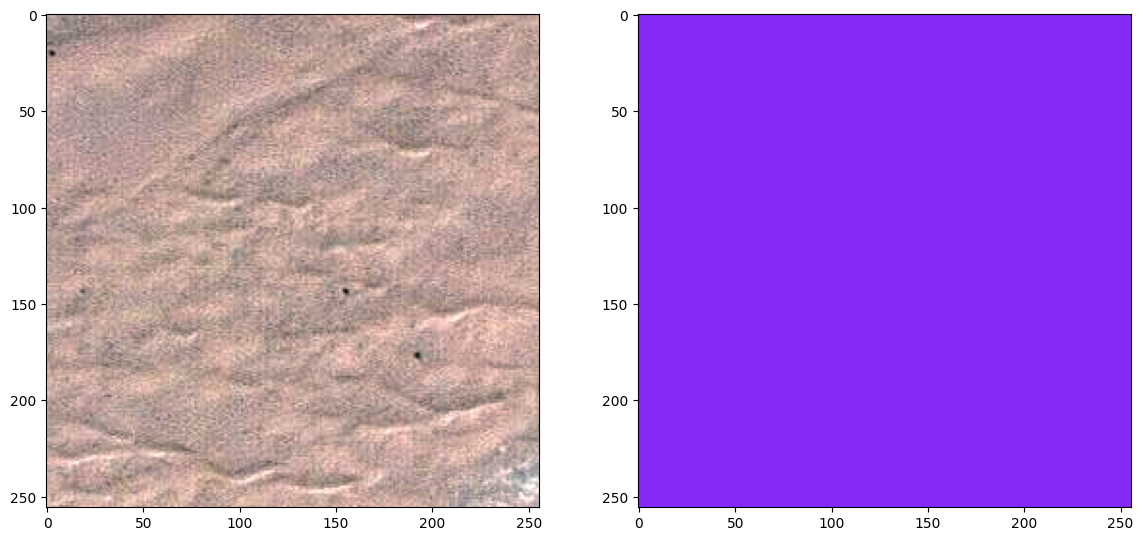

In [23]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [24]:
#based on the jason file provided to us, these hexa codes have to be lablled correctly
class_building = '#3C1098'
class_building = class_building.lstrip('#') # removing the pound sign
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4))) #changing the code based on hexadecimal coding
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [25]:
label = individual_patched_mask

In [26]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0 # All the pixels in label segment corresponding to class water will be labelled 0
  label_segment[np.all(label == class_land, axis=-1)] = 1 #similar for the rest
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0] #converts all multi channel label segment mask to a single segment
  #print(label_segment)
  return label_segment

In [27]:
labels = []
for i in range(mask_dataset.shape[0]): #iterates over each mask image in the mask dataset
  label = rgb_to_label(mask_dataset[i]) #converts rgb to label
  labels.append(label)

In [28]:
print(len(labels))

945


In [29]:
labels = np.array(labels)

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)
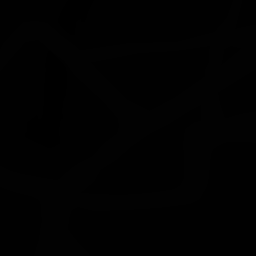

In [30]:
labels[3]

In [31]:
labels = np.expand_dims(labels, axis=3)

In [32]:
labels[3]

array([[[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       ...,

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]]], dtype=uint8)

In [33]:
np.unique(labels) #unique labels

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [34]:
total_classes = len(np.unique(labels))
total_classes

6

In [35]:
from tensorflow.keras.utils import to_categorical

In [36]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [37]:
labels_categorical_dataset.shape

(945, 256, 256, 6)

In [38]:
master_trianing_dataset = image_dataset

In [39]:
master_trianing_dataset.shape

(945, 256, 256, 3)

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
#splitting data into train test split
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [42]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [ ]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [ ]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [ ]:
!pip install -U segmentation-models

Data Modelling: Building a U-Net model from scratch

In [ ]:
#importing libraries from keras for data modelling
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [ ]:
from keras import backend as K # most of the calculations at tensor level, go back to the backend

In [ ]:
def jaccard_coef(y_true, y_pred): # Intersection over Union is an evaluation coefficient
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value


In [ ]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):
  # Built the U-net model based on its original architecture

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [ ]:
metrics = ["accuracy", jaccard_coef]

In [ ]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [ ]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [ ]:
model = get_deep_learning_model()

In [ ]:
#model.get_config()

In [ ]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666] #equal weight distribution

In [ ]:
!pip install keras segmentation_models

In [ ]:
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==2.2.1
ERROR: Could not find a version that satisfies the requirement keras==2.5 (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.4.2,

In [ ]:
dice_loss = sm.losses.DiceLoss(class_weights = weights) # loss in the spatial overlap between these images

In [ ]:
focal_loss = sm.losses.CategoricalFocalLoss()

In [ ]:
total_loss = dice_loss + (1 * focal_loss) #combining dice loss and focal loss

In [ ]:
import tensorflow as tf

In [ ]:
tf.keras.backend.clear_session()


In [ ]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [ ]:
model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=100,
                          validation_data=(X_test, y_test),
                          shuffle=False)

Epoch 1/100
51/51 [==============================] - 52s 401ms/step - loss: 0.9972 - accuracy: 0.5822 - jaccard_coef: 0.2803 - val_loss: 0.9899 - val_accuracy: 0.6568 - val_jaccard_coef: 0.2852
Epoch 2/100
51/51 [==============================] - 11s 217ms/step - loss: 0.9766 - accuracy: 0.6823 - jaccard_coef: 0.3804 - val_loss: 0.9694 - val_accuracy: 0.6849 - val_jaccard_coef: 0.4261
Epoch 3/100
51/51 [==============================] - 11s 220ms/step - loss: 0.9625 - accuracy: 0.7188 - jaccard_coef: 0.4559 - val_loss: 0.9672 - val_accuracy: 0.6936 - val_jaccard_coef: 0.4689
Epoch 4/100
51/51 [==============================] - 11s 218ms/step - loss: 0.9530 - accuracy: 0.7429 - jaccard_coef: 0.5018 - val_loss: 0.9705 - val_accuracy: 0.6986 - val_jaccard_coef: 0.4819
Epoch 5/100
51/51 [==============================] - 11s 219ms/step - loss: 0.9500 - accuracy: 0.7510 - jaccard_coef: 0.5132 - val_loss: 0.9829 - val_accuracy: 0.6658 - val_jaccard_coef: 0.4277
Epoch 6/100
51/51 [===========

In [ ]:
history_a = model_history

In [ ]:
history_a.history

{'loss': [0.9972150921821594,
  0.9765758514404297,
  0.9625012278556824,
  0.9530035257339478,
  0.9499854445457458,
  0.9460548758506775,
  0.9412534236907959,
  0.9371982216835022,
  0.9347456693649292,
  0.9302014708518982,
  0.9281378388404846,
  0.925290584564209,
  0.9238571524620056,
  0.9274927973747253,
  0.920382559299469,
  0.9191148281097412,
  0.917349100112915,
  0.9174185991287231,
  0.9170269966125488,
  0.9142560958862305,
  0.913352370262146,
  0.9124876856803894,
  0.9117122888565063,
  0.9106414318084717,
  0.9099173545837402,
  0.9095403552055359,
  0.9083119034767151,
  0.9076614379882812,
  0.9059844017028809,
  0.9076486229896545,
  0.9077305793762207,
  0.9071272015571594,
  0.9064431190490723,
  0.9043748378753662,
  0.9046181440353394,
  0.9045675992965698,
  0.9049341082572937,
  0.9034229516983032,
  0.9029269814491272,
  0.9046956300735474,
  0.9035589694976807,
  0.9015862941741943,
  0.9001392126083374,
  0.8990397453308105,
  0.8981242775917053,
  0.89

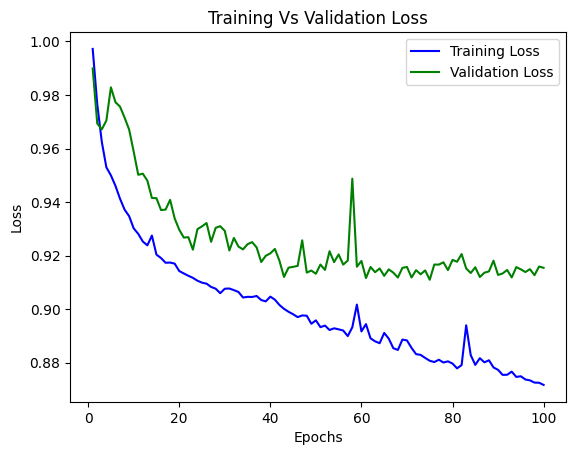

In [ ]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label="Training Loss")
plt.plot(epochs, val_loss, 'g', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

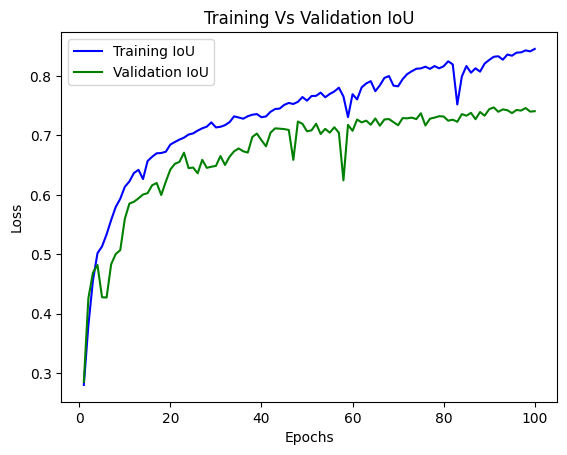

In [ ]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'b', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'g', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model_history.params

{'verbose': 1, 'epochs': 100, 'steps': 51}

In [ ]:
y_pred = model.predict(X_test)

5/5 [==============================] - 5s 61ms/step


In [ ]:
len(y_pred)

142

In [ ]:
y_pred

array([[[[5.77855017e-03, 4.89304513e-01, 9.77338478e-02,
          3.39269251e-01, 6.63651302e-02, 1.54873263e-03],
         [9.13492811e-04, 5.27008057e-01, 4.49864604e-02,
          4.03600574e-01, 2.33956166e-02, 9.58465462e-05],
         [6.05245063e-04, 4.19921279e-01, 3.05549428e-02,
          5.35557687e-01, 1.33090010e-02, 5.18219640e-05],
         ...,
         [5.41219779e-04, 3.75160068e-01, 1.89782493e-02,
          5.92265189e-01, 1.29902484e-02, 6.50676957e-05],
         [5.16175351e-04, 4.25108403e-01, 2.28271112e-02,
          5.35507083e-01, 1.59763899e-02, 6.48054338e-05],
         [3.51822679e-03, 4.14371103e-01, 6.12212270e-02,
          4.65590239e-01, 5.47280535e-02, 5.71157143e-04]],

        [[1.07112736e-03, 4.89311069e-01, 4.24164683e-02,
          4.43161517e-01, 2.38782782e-02, 1.61567776e-04],
         [9.07642752e-05, 4.59893167e-01, 1.21014593e-02,
          5.23598850e-01, 4.31204960e-03, 3.72178170e-06],
         [1.02481201e-04, 3.93566549e-01, 8.3994

In [ ]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [ ]:
len(y_pred_argmax)

142

In [ ]:
y_pred_argmax

array([[[1, 1, 3, ..., 3, 3, 3],
        [1, 3, 3, ..., 3, 3, 3],
        [1, 1, 3, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 3, 3, 3],
        [1, 2, 2, ..., 3, 3, 3],
        [2, 2, 2, ..., 3, 3, 3],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [ ]:
y_test_argmax = np.argmax(y_test, axis=3)

In [ ]:
y_test_argmax

array([[[3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 1, ..., 0, 0, 0]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [ ]:
import random

In [ ]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 1s 903ms/step


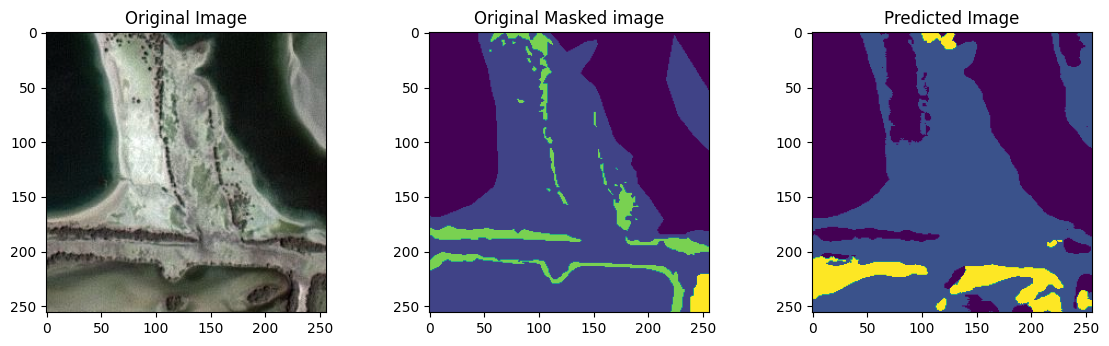

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)


In [ ]:
model.save("satellite_segmentation_full.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
